# Sequential data modelling
In this notebook we will work with the Jena weather dataset. "The dataset is recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany." [source](https://www.kaggle.com/pankrzysiu/weather-archive-jena). The data is collected over the years 2009-2016. Using this dataset we will try to predict the temperature in the future.

We will start by preprocessing the data, reshape it, scale it, and split it to train/val/test. The reshaping step is new and very common when dealing with sequential data.

After preprocessing the data we will create a baseline model (dense network) and see how well it performs on this data.

As usual we start by loading our data.

In [2]:
library(keras)
library(ggplot2)
source("04-helpers.R")

use_multi_cpu(2L) # Remove this line if you are running in a local environment.

In [3]:
data <- load_jena_dataset() # This will download the dataset into a folder "data"

Parsed with column specification:
cols(
  `Date Time` = col_character(),
  `p (mbar)` = col_double(),
  `T (degC)` = col_double(),
  `Tpot (K)` = col_double(),
  `Tdew (degC)` = col_double(),
  `rh (%)` = col_double(),
  `VPmax (mbar)` = col_double(),
  `VPact (mbar)` = col_double(),
  `VPdef (mbar)` = col_double(),
  `sh (g/kg)` = col_double(),
  `H2OC (mmol/mol)` = col_double(),
  `rho (g/m**3)` = col_double(),
  `wv (m/s)` = col_double(),
  `max. wv (m/s)` = col_double(),
  `wd (deg)` = col_double()
)


## Excercise 1
As usual, explore the data a bit. What are the names of the columns/features? How many examples do we have?

**Hint** these column names have spaces in the name so refering to them using `data$col a` will not work, instead do `data$"col a"`

In [4]:
names(data)
dim(data)
length(data$"T (degC)")

[1] "Date Time"       "p (mbar)"        "T (degC)"        "Tpot (K)"       
 [5] "Tdew (degC)"     "rh (%)"          "VPmax (mbar)"    "VPact (mbar)"   
 [9] "VPdef (mbar)"    "sh (g/kg)"       "H2OC (mmol/mol)" "rho (g/m**3)"   
[13] "wv (m/s)"        "max. wv (m/s)"   "wd (deg)"

[1] 420551     15

[1] 420551

We want to predict the temperature, `T (degC)`. Let us plot that feature and see how the temperature varies over those years.

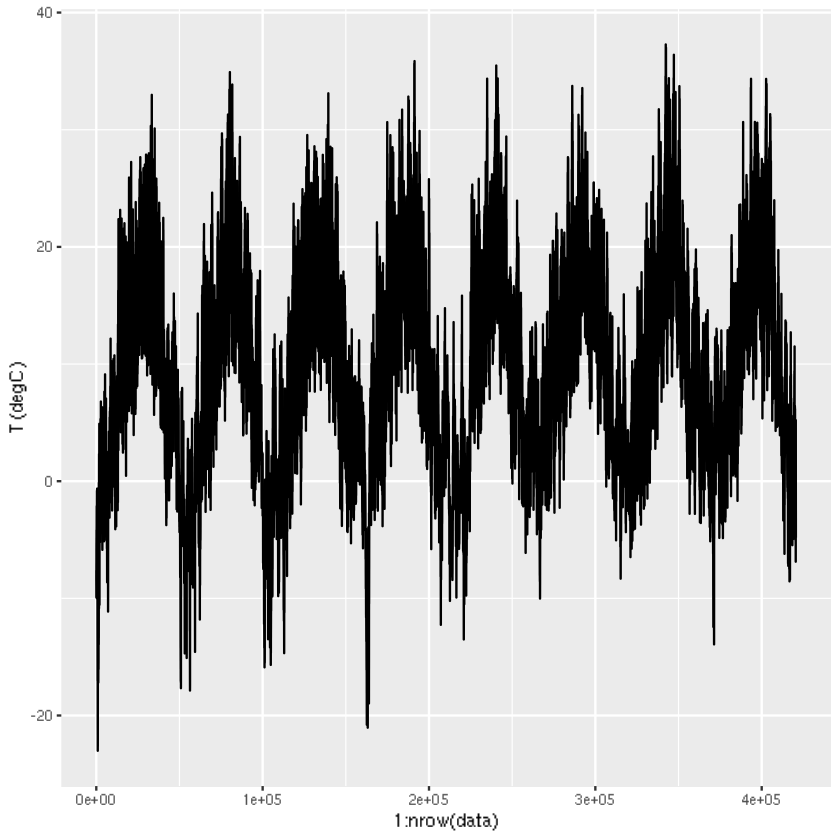

In [5]:
ggplot(data, aes(x = 1:nrow(data),y=`T (degC)`)) + geom_line()

## Excercise 2
Looking at the plot above. How many years worth of data do we have? To answer this, just try counting the peaks. What do the peaks represent?

We have about 8 years of data. The peaks (or valleys) are the summers (winters).

These are quite many measurements. In fact, a new measurement is drawn every 10 minutes, 6 measurements and hour, 6*24=144 measurements a day. Let us plot 10 days (144 * 10) of measurements. Starting from day 60.

Feel free change the start_day or the duration.

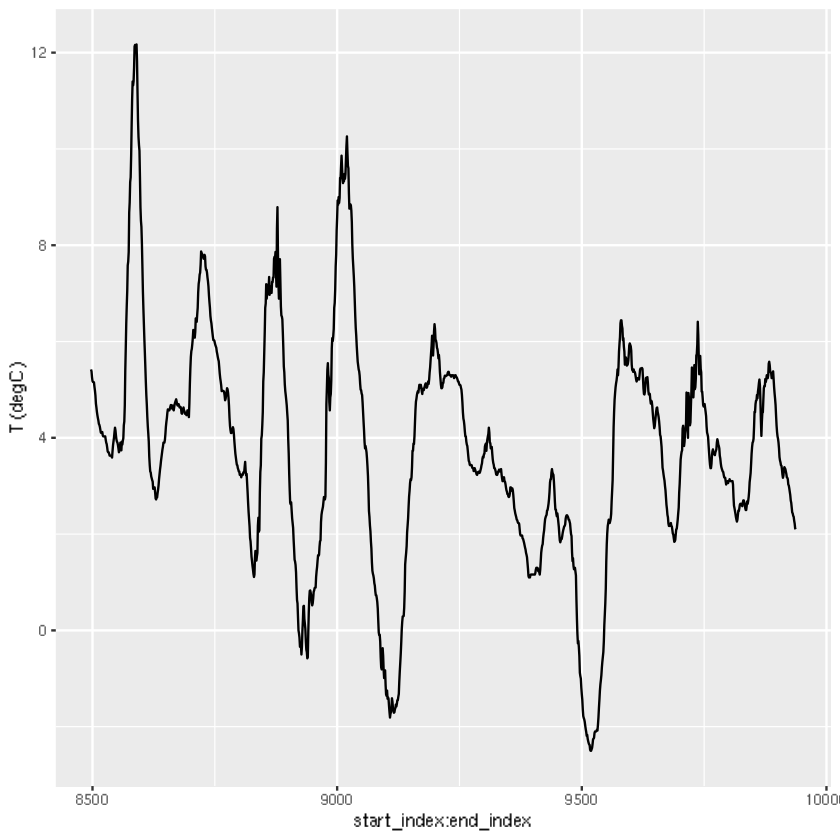

In [6]:
start_day = 60 
duration_days = 10
measurements_per_day = 6*24
start_index = 1 + (start_day - 1) * measurements_per_day
end_index = start_index + duration_days * measurements_per_day
ggplot(data[start_index:end_index,], aes(x = start_index:end_index, y = `T (degC)`)) + geom_line()

## Preprocessing

Today we will need to spend some additional time preprocessing our data. This is because our sequential model will expect to get the data in dimensions `(examples, sequence_length, features)`. This will impact other preprocessing stages as well.

Let us start with a basic step, removing features which we will not use and change our data object to a matrix.

## Excercise 3.1
Remove the `Date Time` feature from `data` and store the result in a variable called `features`. Verify that you have done this correctly by calling `names()` on `features` and check the `dim()`. The data should have dimension `(420551, 14)`.

**Hint** `Date Time` is the first column in `data`.

In [7]:
features <- data[,-1]
dim(features)

[1] 420551     14

## Excercise 3.2
Now let us change `features` into a matrix. The type is important for our reshape step.. First check the type of `features` using the `typeof()` function. Then map `features` to a new variable `feature_matrix` by using the function `as.matrix()`. Verify that it has type `double`.

In [8]:
typeof(features)
feature_matrix <- as.matrix(features)
typeof(feature_matrix)

[1] "list"

[1] "double"

## Reshaping
Now `feature_matrix` is of the correct type and contains all our features. Now we need to "reshape" this matrix (2D tensor) to an array (3D tensor). That is we need to change the dimensions from `(examples, features)` to `(examples, sequence_length, features)`. This is because sequence models expect the input to have shape `(examples, sequence_length, features)`. We need to create sequences out of multiple examples and we do this by reshaping our data. Let us see how the [`reshape()`](https://rstudio.github.io/reticulate/reference/array_reshape.html) function works.

## Excercise 4.1
Reshape the vector (1D tensor) `vec` to a `(2,2)` matrix (2D tensor).

In [9]:
vec <- 1:4
vec
mat <- array_reshape(vec, c(2, 2))
mat

[1] 1 2 3 4

1,2
3,4


The reshape function expects our inputs to fit perfectly into the new tensor. We can not reshape the vector above to a tensor with dimensions `(2,2,2)` as it requires 8 values.

## Excercise 4.2
Create a vector (1D tensor) with 8 elements (a sequence like above) and reshape it into a 3D tensor called `tensor`. 

In [10]:
vec <- 1:8
tensor <- array_reshape(vec, c(2, 2, 2))

Run the cell below to verify that your solution worked and notice the ordering of elements.

In [11]:
tensor[1,,]
tensor[2,,]

1,2
3,4


5,6
7,8


Going back to our task. Our data has the shape `(examples, features)` (2D tensor) and we need to reshape it to `(examples, sequence_length, features)` (3D tensor) by reducing the `examples` dimension. Run the example below to see how we might do this.

In [12]:
example_1 <- 1:3
example_2 <- 11:13
example_3 <- 111:113
example_4 <- 1111:1113
x <- matrix(c(example_1, example_2, example_3, example_4), nrow = 4, byrow = TRUE)
dim(x)
x[1,]
x[2,]
x[3,]
x[4,]

[1] 4 3

[1] 1 2 3

[1] 11 12 13

[1] 111 112 113

[1] 1111 1112 1113

`x` represents our data but only has 4 examples, each with 3 features, `(4,3)`. Let us now reshape it to so that we we 2 examples, each with a sequence of length 2. That is, `(2,2,3)`. We do not change the feature dimension.

In [13]:
reshaped_x <- array_reshape(x, c(2,2,3))
reshaped_x[1,,]
reshaped_x[2,,]

1,2,3
11,12,13


111,112,113
1111,1112,1113


We can still use the `apply` function on `reshaped_x`. The cell below will sum each feature over all the examples. This will help us scale our data later.

In [14]:
apply(reshaped_x, 3, sum)

[1] 1234 1238 1242

Success!

## Excercise 4.3
Reshape `feature_matrix` so that it becomes a 3D tensor with dimensions `(1752, 240, 14)`. By doing this we are create 1752 sequences of length 240. For this to work `feature_matrix` needs to fit into a 3D tensor, so only take the first 1752*240=420.480 elements from `feature_matrix`. Store the result in a variable called `feature_matrix_reshaped`. Verify the dimensions after reshaping.

In [15]:
sequence_length <- 240
dim(feature_matrix)
feature_matrix_reshaped <- array_reshape(x = feature_matrix[1:420480,], dim = list(1752, sequence_length, 14))
dim(feature_matrix_reshaped)

[1] 420551     14

[1] 1752  240   14

Wow! This was a lot of work, but well worth it, as understanding how the `array_reshape()` function works is very helpful.

## Splitting
Now we will split our `feature_matrix_reshaped` into train/val/test sets. We will, like usual, only split on the `examples` axis. To make the splits easy to understand and debug we will store 6 indices, one for where each section begins and ends.

## Excercise 5.1
Create the following 6 indices.
- train_start_index
- train_end_index
- val_start_index
- val_end_index
- test_start_index
- test_end_index

Create these 6 indices so that:
- `train_start_index = 1`
- after the training set the validation set starts
- after the validation set ends, the test set starts
- `test_end_index = 1752`
- Use the normal sizes of splits 0.8\*0.8 / 0.8\*0.2 / 0.2 for train/val/test.
- Use `dim(feature_matrix_reshaped)[1]` to get the number of examples.

**Hint** Be sure to return integers by using the function `as.integer( some_decimal )`. You can take a look at code of the previous notebooks for syntax help.

In [16]:
train_start_index <- 1
train_end_index <- train_start_index + as.integer(0.8 * 0.8 * dim(feature_matrix_reshaped)[1]) - 1
val_start_index <- train_end_index + 1
val_end_index <- val_start_index + as.integer(0.8 * 0.2 * dim(feature_matrix_reshaped)[1]) - 1
test_start_index <- val_end_index + 1
test_end_index <- test_start_index + as.integer(0.2 * dim(feature_matrix_reshaped)[1])

Run the cell below to verify that all the indices are correct, they should **roughly** be (it does not need to be exactly the same, off by 1 or 2 is alright):
- train_start_index = 1
- train_end_index = 1121
- val_start_index = 1122
- val_end_index = 1401
- test_start_index = 1402
- test_end_index = 1752

If you are unable to do this, just store the indices as these numbers.

In [17]:
train_start_index
train_end_index
val_start_index
val_end_index
test_start_index
test_end_index

[1] 1

[1] 1121

[1] 1122

[1] 1401

[1] 1402

[1] 1752

## Scaling
Before splitting the `feature_matrix_reshaped` let us scale the features. Today we will scale all our features, even the feature we want to predict. This is because we will use previous values of that feature as input to our model, so we need to scale it. We will only use the training set to compute the mean and standard deviation and use that to scale the whole dataset. 

To only compute the mean and standard deviation on the training set we use the `apply()` function. Verify that this is done correctly in the cell below (not a trick question).

In [18]:
# We compute the mean and sd for each feature independently, The features are on the 3rd axis.
mean <- apply(feature_matrix_reshaped[train_start_index:train_end_index,,], 3, mean)
std <- apply(feature_matrix_reshaped[train_start_index:train_end_index,,], 3, sd)

mean[2] # The mean temperature
mean[1] # The mean air pressure

[1] 8.736798

[1] 988.6792

This time we will not use the `scale()` function since it only works with (at most) 2D tensors, so we need to do this manually. We store the result in `feature_matrix_reshaped_scaled`. We provide the code for this, but we recommend reading through it.

In [19]:
# Create an empty 3D tensor with same dimensions as feature_matrix_reshaped.
feature_matrix_reshaped_scaled <- array(0, dim = dim(feature_matrix_reshaped))

# For each feature we subtract the mean and divide by the std.
for (j in 1:dim(feature_matrix_reshaped)[3]) {
    feature_matrix_reshaped_scaled[,,j] <- (feature_matrix_reshaped[,,j] - mean[j]) / std[j]
}

Let us see if this all makes sense and check the first temperature.

In [20]:
feature_matrix_reshaped[1,1,2]
feature_matrix_reshaped_scaled[1,1,2]

[1] -8.02

[1] -1.922712

Brr... A cold day.

## Excercise 5.2
Now we can finish splitting the data into train/val/test sets. Create the 3 datasets `train_data`, `val_data` and `test_data` based on the indices above and the `feature_matrix_reshaped_scaled` data and verify the dimensions. Again, take a look at the previous notebooks for some syntax guidance.

In [21]:
train_data <- feature_matrix_reshaped_scaled[train_start_index:train_end_index,,]
val_data <- feature_matrix_reshaped_scaled[val_start_index:val_end_index,,]
test_data <- feature_matrix_reshaped_scaled[test_start_index:test_end_index,,]
dim(train_data)
dim(val_data)
dim(test_data)
(dim(train_data)[1] + dim(val_data)[1])/(dim(test_data)[1] + dim(train_data)[1] + dim(val_data)[1])

[1] 1121  240   14

[1] 280 240  14

[1] 351 240  14

[1] 0.7996575

## The predictions
Now we have successfully scaled and split our dataset. The last step is to create the correct predictions. For each sequences we need to create a corresponding target. To do this, we need to select a temperature point somewhere in the future and predict it. Let us try to predict the temperature for the next day, that is, 144 timesteps into the future.

To explain this further let us take an example. The first training sequence we have is `train_data[1,,]`. It contains 240 measurements, each made out of 14 features. We need to select the temperature 144 timesteps into the future from the last measurement in our sequence. This temperature is in the next training example, at `train_data[2,144,2]`.

Let us now do this systematically for each dataset.

## Excercise 6.1
Create `y_train`, `y_val` and `y_test` from `train_data`, `val_data` and `test_data`, respectively. These will be our targets, `y`. Fill in the missing information to the cell below. Verify that the dimensions are correct (these will be vectors, so use the `length()` function). 

**Hint** There should be 1 fewer elements in the `y`'s since we cannot use the first sequence to use a prediction for anything. We will address this in the next excercise.

In [22]:
y_train <- train_data[(2:dim(train_data)[1]), 144, 2]
length(y_train)
y_val <- val_data[(2:dim(val_data)[1]), 144, 2]
length(y_val)
y_test <- test_data[(2:dim(test_data)[1]), 144, 2]
length(y_test)

[1] 1120

[1] 279

[1] 350

Since we needed to use the temperature from the next example to create our predictions, we would need to use the temperature from the first sequence in validation set as the correct prediction for the last sequence in the training set, and so on. We cannot be bothered to do that and we just skip the last sequence in the training data as input.

## Excercise 6.2
Create `x_train`, `x_val` and `x_test` from the `train_data`, `val_data` and `test_data`, respectively. Do not include the last sequence in `train_data` (and `val_data` and `test_data`) since we do not have the correct prediction for the last sequence in `y_train` (and `y_val` and `y_test`). Verify that `dim(x_train)[1]` is equal to `length(y_train)`.

In [23]:
x_train <- train_data[(1:dim(train_data)[1] - 1),,]
x_val <- val_data[(1:dim(val_data)[1] - 1),,]
x_test <- test_data[(1:dim(test_data)[1] - 1),,]
dim(x_train)[1]
length(y_train)

[1] 1120

[1] 1120

We are finally done with all of the preprocessing. Wow! This was a lot of work! This is amount of preprocessing for sequential models is quite common as you want to be able to change many of the decisions we made in these steps. For example, we might want to increase/decrease timesteps in each sequence or predict longer/shorter into the future. This would not be possible if these preprocessing steps were done for us.

## The baseline model
Now we want to create a dense network model to serve as our baseline. We then want to see the improvement we can get by adding an RNN.

In this model notice a few things.
- The dense networks expect input to be a vector, so the first layer in the network will flatten out the sequences (reversing a lot of our hard, reshape work).
- Only a single hidden layer.
- Since we are doing regression, the last layer has a single unit and no activation.
- We use the mean absolute error, `mae`. It worked better.

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten (Flatten)                   (None, 3360)                    0           
________________________________________________________________________________
dense (Dense)                       (None, 12)                      40332       
________________________________________________________________________________
dense_1 (Dense)                     (None, 1)                       13          
Total params: 40,345
Trainable params: 40,345
Non-trainable params: 0
________________________________________________________________________________


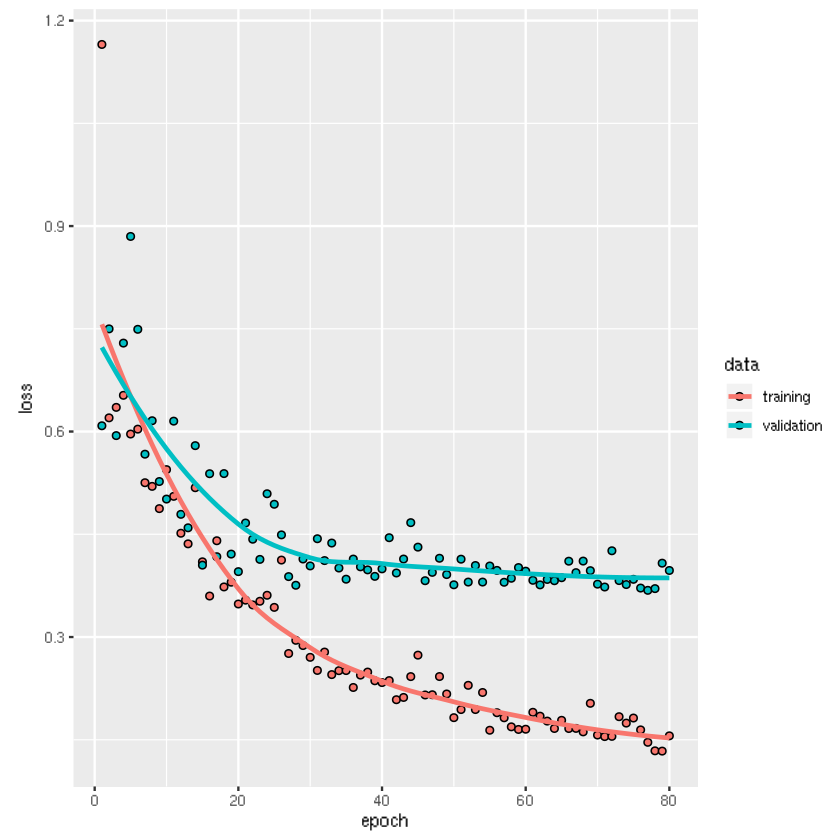

In [24]:
model <- keras_model_sequential() %>%
    layer_flatten(input_shape = c(sequence_length, 14)) %>%
    layer_dense(units = 12, activation = 'relu') %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 80,
    batch_size = 32,
    callbacks=list(Progress$new())
)

plot(history)

Feel free to tweak the model a bit and then evaluate your model when you are done.

In [25]:
model %>% evaluate(x_test, y_test)

loss 
2.968956

Now we do the same for a simple RNN network. In this network notice:
- A single RRN layer.
- Very few parameters, we use the same weights for every 240 timestep.
- Fewer epochs.
- Same loss.
- Slow training (because of all the timesteps we have)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
simple_rnn (SimpleRNN)              (None, 12)                      324         
________________________________________________________________________________
dense_2 (Dense)                     (None, 1)                       13          
Total params: 337
Trainable params: 337
Non-trainable params: 0
________________________________________________________________________________


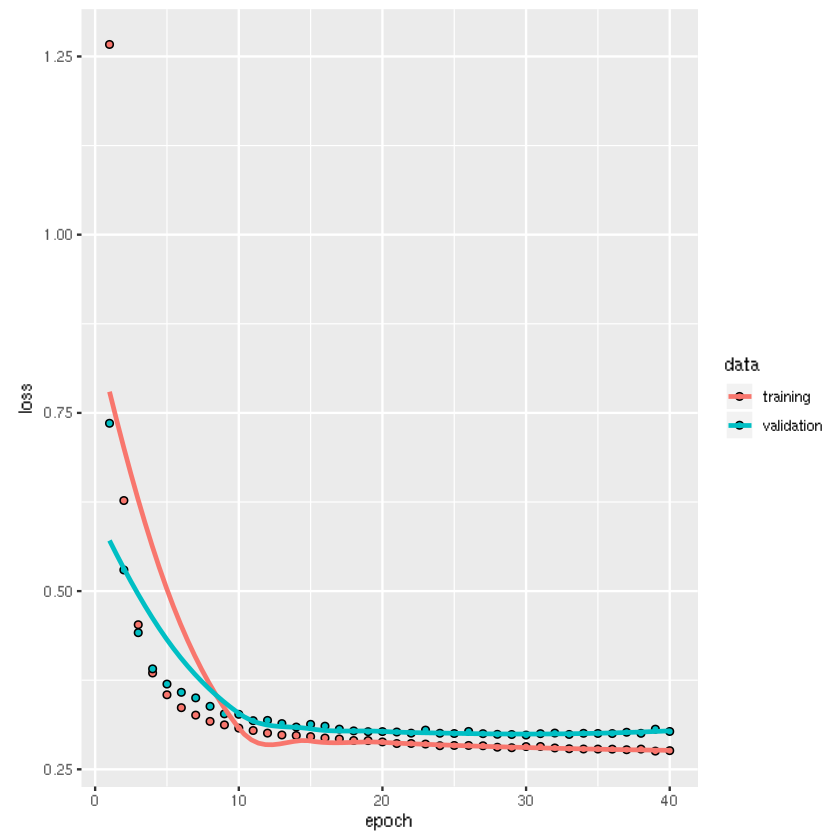

In [26]:
model <- keras_model_sequential() %>%
    layer_simple_rnn(units = 12, input_shape = c(sequence_length, 14)) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_data = list(x_val, y_val),
    epochs = 40,
    batch_size = 32,
    callbacks=list(Progress$new())
)

plot(history)

Feel free to tweak the model a bit and then evaluate your model when you are done. You will notice that there is a lot more variation in the dense network than in the RNN.

In [27]:
model %>% evaluate(x_test, y_test)

loss 
0.3088177

Now we are finished! In this notebook worked with the Jena weather dataset. We first preprocessed the data using the reshape function, to create sequences. Then we scaled the data "manually" and finally split it to train/dev/test.

We then established a baseline model, a dense network and then tried a simple RNN network. We saw that the RNN performed a lot more consistently, better, had way fewer parameters, but also took longer to train due to our long sequences.

## Bonus excercise
Scaling the temperature in the predictions, `y`, is not as nice as having them as the correct celsius values. Repeat the processing pipeline for `y` without scaling the predictions. Then run the same model using these predictions.

## Bonus excercise
Try using the [`predict`](https://keras.rstudio.com/reference/predict.keras.engine.training.Model.html) function. This is the function you would run "in production" to get the actual predictions. Remember to shift and scale the output with the mean and std we computed earlier.